In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')
data.shape

(22695, 2)

In [3]:
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


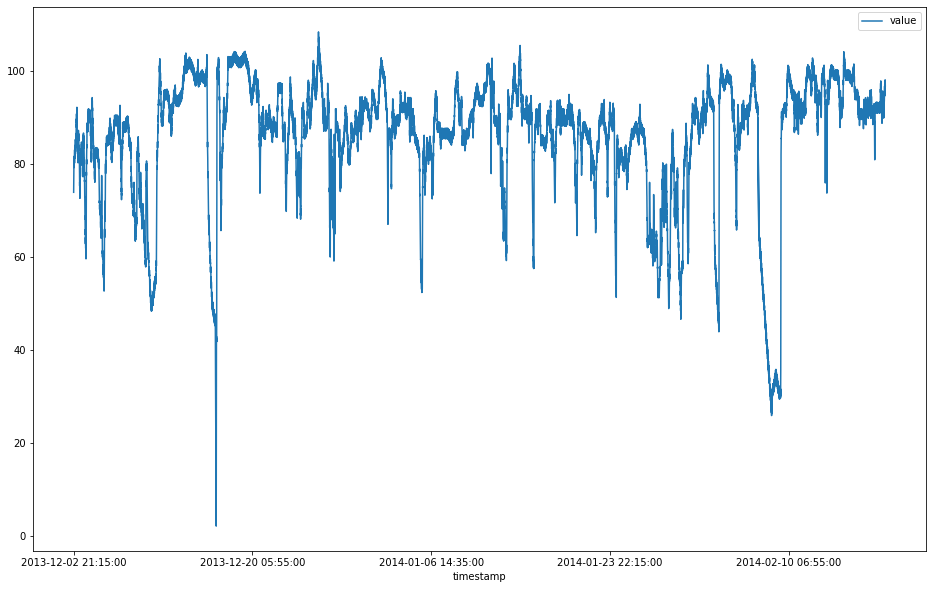

In [4]:
data.set_index('timestamp').plot(figsize=(16, 10))

In [5]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((20424, 1), (20424, 1), (2270, 1), (2270, 1))

In [6]:
X[1, :], y[0, :]

(array([74.935882]), array([74.935882]))

In [7]:
n_timesteps = 48
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]

In [8]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
X_train = np.concatenate(X_train_list, axis=0)
y_train = y_train[n_timesteps-1:, :]

X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val = np.concatenate(X_val_list, axis=0)
y_val = y_val[n_timesteps-1:, :]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((20377, 48, 1), (20377, 1), (2223, 48, 1), (2223, 1))

In [9]:
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))
    
    x = LSTM(50, return_sequences=True)(i)
    x = Dropout(0.4)(x)
    
    x = LSTM(50)(x)
    x = Dropout(0.4)(x)

    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [10]:
model = Autoencoder(n_timesteps, n_features)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 48, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                

In [11]:
model = Autoencoder(n_timesteps, n_features)
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=10, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/10
160/160 [==============================] - 2s 12ms/step - loss: 42.9076 - val_loss: 12.1237
Epoch 2/10
160/160 [==============================] - 1s 8ms/step - loss: 12.8309 - val_loss: 9.4112
Epoch 3/10
160/160 [==============================] - 1s 8ms/step - loss: 12.6369 - val_loss: 9.3616
Epoch 4/10
160/160 [==============================] - 1s 8ms/step - loss: 12.6076 - val_loss: 9.4650
Epoch 5/10
160/160 [==============================] - 1s 7ms/step - loss: 12.6961 - val_loss: 9.4224
Epoch 6/10
160/160 [==============================] - 1s 8ms/step - loss: 12.5227 - val_loss: 9.5002
Epoch 7/10
160/160 [==============================] - 1s 8ms/step - loss: 12.5533 - val_loss: 9.4602
Epoch 8/10
160/160 [==============================] - 1s 8ms/step - loss: 12.5197 - val_loss: 9.4771
Epoch 9/10
160/160 [==============================] - 1s 8ms/step - loss: 12.3950 - val_loss: 6.6490
Epoch 10/10
160/160 [==============================] - 1s 8ms/step - loss: 9.5597 - val_l

In [12]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(20377, 1)

In [13]:
from sklearn.metrics import mean_absolute_error
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

20377

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


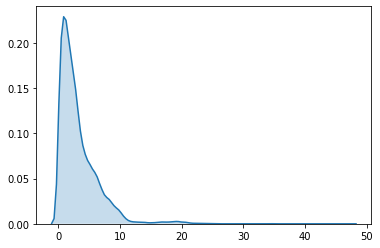

In [14]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

In [15]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(3.246652140487314, 3.242268607040648)

In [16]:
def is_anomaly(error, mean, std, threshold):
    delta = np.abs(error - mean)
    multiple = delta / std
    if multiple < threshold:
        return 0
    else:
        return 1

In [17]:
y_val_pred = model.predict(X_val[:10, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
result = [is_anomaly(x, dist.mean(), dist.std(), 2) for x in val_errors]
print(result)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

In [19]:
result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]
print(result)

[0.5483, 0.8195, 0.6096, 0.5831, 0.6941, 0.707, 0.6507, 0.7568, 0.6997, 0.532]
